<a href="https://colab.research.google.com/github/svandergoote/LGBIO2060-2021/blob/main/LGBIO2060_TP5_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LGBIO2060 Exercise session 5

#Kalman filter

__Authors:__ Simon Vandergooten, Clémence Vandamme

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy


## Import and helper functions
**Please execute the cell below to initialize the notebook environment**

In [1]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import namedtuple

In [2]:
#@title Utility functions
def plot_my_system(state_evolution):
  """
  Do not edit this function...

  the aim of this function is to represent the time-evolution of a dynamical linear system
  Author : Antoine de Comite 
  """
  fig, ax = plt.subplots(figsize=(8,6))
  xlim = None
  ylim = None
  ax.scatter(state_evolution[0,:],state_evolution[1,:],c='m',s=100,alpha=0.7)
  ax.plot(state_evolution[0,:],state_evolution[1,:],LineWidth=2,c='k')
  ax.set_xlabel("x_1")
  ax.set_ylabel("x_2")
  ax.set(xlim=xlim)
  ax.set(ylim=ylim)
  plt.plot()
  return ax

def plot_my_system_with_obs(state_evolution,obs_evolution):
  """
  Do not edit this function...

  the aim of this function is to represent the time-evolution of a dynamical linear system
  Author : Antoine de Comite 
  """
  fig, ax = plt.subplots(figsize=(8,6))
  xlim = None
  ylim = None
  ax.scatter(state_evolution[0,:],state_evolution[1,:],c='m',s=100,alpha=0.7)
  ax.plot(state_evolution[0,:],state_evolution[1,:],LineWidth=2,c='k',label='Latent state')
  ax.plot(obs_evolution[0,:],obs_evolution[1,:],LineWidth=2,c='g',label='Observation')
  ax.set_xlabel("x_1")
  ax.set_ylabel("x_2")
  ax.set(xlim=xlim)
  ax.set(ylim=ylim)
  ax.legend()
  plt.plot()
  return ax

def plot_my_kalman_filter(state_evolution,obs_evolution,estimated_evolution):
  """
  DO NOT EDIT THIS FUNCTION
  author : antoine de Comite 
  """

  fig,ax = plt.subplots(figsize=(8,6))
  xlim = None; ylim = None
  ax.scatter(state_evolution[0,:-1],state_evolution[1,:-1],c='m',s=100,alpha=0.7)
  ax.plot(state_evolution[0,:-1],state_evolution[1,:-1],LineWidth=2,c='k',label='Latent state')
  ax.plot(obs_evolution[0,:-1],obs_evolution[1,:-1],LineWidth=2,c='g',label='Observation')
  ax.plot(estimated_evolution[0,:-1],obs_evolution[1,:-1],LineWidth=2,c='r',label='Estimation')
  ax.set_xlabel("x_1")
  ax.set_ylabel("x_2")
  ax.set(xlim=xlim)
  ax.set(ylim=ylim)
  ax.legend()
  plt.plot()
  return ax


gaussian = namedtuple('Gaussian', ['mean', 'cov'])
def filter(D, process_noise, measurement_noise, posterior, m):
    todays_prior = gaussian(D * posterior.mean, D**2 * posterior.cov + process_noise)
    likelihood = gaussian(m, measurement_noise)

    info_prior = 1/todays_prior.cov
    info_likelihood = 1/likelihood.cov
    info_posterior = info_prior + info_likelihood

    prior_weight = info_prior / info_posterior
    likelihood_weight = info_likelihood / info_posterior
    posterior_mean = prior_weight * todays_prior.mean  +  likelihood_weight * likelihood.mean

    posterior_cov = 1/info_posterior
    todays_posterior = gaussian(posterior_mean, posterior_cov)
    """
    prior = gaussian(belief.mean, belief.cov)

    predicted_estimate = D * belief.mean
    predicted_covariance = D**2 * belief.cov + process_noise

    likelihood = gaussian(m, measurement_noise)
    innovation_estimate = m - predicted_estimate
    innovation_covariance = predicted_covariance + measurement_noise

    K = predicted_covariance / innovation_covariance  # Kalman gain, i.e. the weight given to the difference between the measurement and predicted measurement
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K) * predicted_covariance
    todays_posterior = gaussian(updated_mean, updated_cov)
    """
    return todays_prior, likelihood, todays_posterior

def paintMyFilter(D, initial_guess, process_noise, measurement_noise, s, m, s_, cov_):
    # Compare solution with filter function
    T = 50
    t = np.arange(0, T, 1)
    filter_s_ = np.zeros(T)    # estimate (posterior mean)
    filter_cov_ = np.zeros(T)    # uncertainty (posterior covariance)

    filter_s_ = s_
    filter_cov_ = cov_
    posterior = initial_guess
    filter_s_[0] = posterior.mean
    filter_cov_[0] = posterior.cov

    process_noise_std = np.sqrt(process_noise)
    measurement_noise_std = np.sqrt(measurement_noise)

    for i in range(1, T):
        prior, likelihood, posterior = filter(D, process_noise, measurement_noise, posterior, m[i])
        filter_s_[i] =  posterior.mean
        filter_cov_[i] = posterior.cov

    smin = min(min(m),min(s-2*np.sqrt(cov_[-1])),min(s_-2*np.sqrt(cov_[-1])))
    smax = max(max(m),max(s+2*np.sqrt(cov_[-1])),max(s_+2*np.sqrt(cov_[-1])))
    pscale = 0.2  # scaling factor for displaying pdfs

    fig = plt.figure(figsize=[15, 10])
    ax = plt.subplot(2, 1, 1)
    ax.set_xlabel('time')
    ax.set_ylabel('state')
    ax.set_xlim([0, T+(T*pscale)])
    ax.set_ylim([smin, smax])

    ax.plot(t, s, color='limegreen', lw=2, label='Fly´s trajectory')
    ax.plot([t[-1]], [s[-1]], marker='o', markersize=8, color='limegreen')

    ax.plot(t, m, '.', color='crimson', lw=2, label='measurements')
    ax.plot([t[-1]], [m[-1]], marker='o', markersize=8, color='crimson')

    ax.plot(t, filter_s_, color='black', lw=2, label='correct estimated trajectory')
    ax.plot([t[-1]], [filter_s_[-1]], marker='o', markersize=8, color='black')

    res = '! :)' if np.mean((s_ - filter_s_)**2) < 0.1 else ' :('
    ax.plot(t, s_, '--', color='lightgray', lw=2, label='your estimated trajectory' + res)
    ax.plot([t[-1]], [s_[-1]], marker='o', markersize=8, color='lightgray')

    plt.legend()
    plt.show()
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

def my_system_with_obs1D(nsteps,x0,A,H,omega_motor,omega_sensory):
  """
  my_system_with_obs is a function that model the time-evolution of the latent state 
  and its observation
  Inputs : nsteps is the number of time steps to model
           x0 is the initial state (where we are starting from)
           A is the state-transition matrix
           H is the observation matrix
           omega_motor is the variance of the motor noise
           sigma_sensory is the variance of the sensory noise
  Outputs : state_evolution is a numpy array that contains the time-evolution of 
            the state vector : (state size * nsteps)
            obs_evolution is a numpy array that contains the time-evolution of 
            the observation of the state vector : (state size * nsteps)
  """
  ######################
  ### your code here ###
  ######################
  state_evolution = my_system1D(nsteps, x0, A, omega_motor)

  
  obs_evolution = np.zeros(nsteps)
  for step in range(nsteps):
    noise = np.random.normal(0, np.sqrt(omega_sensory))
    obs_evolution[step] = H * state_evolution[step] + noise
    
  return state_evolution,obs_evolution

def my_system1D(nsteps,x0,A,omega_motor,seed=2060):
  """
  my_system is a function that model the time-evolution of a linear dynamical system
  with state transition matrix A.
  Inputs : nsteps is the number of time steps to model
           x0 is the initial state (where we are starting from)
           A is the state-transition matrix
           omega_motor is the covariance matrix
  Outputs : state_evolution is a numpy array that contains the time-evolution of 
            the state vector : (state size * nsteps)
  """
  # Set the random generator seed
  np.random.seed(seed)

  ########################
  #### Your code here ####
  ########################
  
  state_evolution = np.zeros(nsteps)
  state_evolution[0] = x0

  means = np.zeros(1)
  for step in range(1,nsteps):
    noise = np.random.normal(means, np.sqrt(omega_motor))
    state_evolution[step] = A * state_evolution[step-1] + noise

  return state_evolution

#Introduction
In this tutorial, you will estimate the true state of a continuous variable. Like in the last session, this state evolves over time. Therefore, at each time step you will use both your prior knowledge (consisting of the previous estimate and the system dynamics) and a new measurement. The continuous adaptation of the Bayes theorem on dynamical sytems is called a *Kalman filter*. 


## Dynamical systems

Like in Hidden Markov Models, one state only depends on the previous state, the past history does not matter. 

In one dimension, you have the following relationship: 

\begin{eqnarray}
& & \\
x\left[t+1\right] & = & a x\left[t\right] + \xi\left[t\right] \\
& & \\
\end{eqnarray}

Where $a$ is a deterministic known parameter and $\xi$ is gaussian motor noise generated from $\mathcal{N}\left(0,\sigma^2\right)$. 

You can easily extend this description to 2 (or more) dimensions with a matrix representation (for example to estimate a position in x- and y- dimension): 

\begin{eqnarray}
&&\\
\begin{bmatrix}
  x_1[t+1] \\
  x_2[t+1]
  \end{bmatrix} &=& \begin{bmatrix}A_{11} & A_{12}\\ A_{21} & A_{22} \end{bmatrix}\begin{bmatrix}x_1[t]\\ x_2[t]\end{bmatrix} + \begin{bmatrix}\xi_1[t] \\ \xi_2[t] \end{bmatrix}
  &&\\
\end{eqnarray}

\\

**Exercise - Implement a function that defines the system mentionned above**

In this first exercise, you are asked to model the dynamical system characterised by the equation above. Let's say that it models the trajectory of a fly. 

Hints : 
* You will be performing matrix multiplications, consider this while implementing your function...

* See the function np.random.multivariate_normal to generate noise for multiple variables


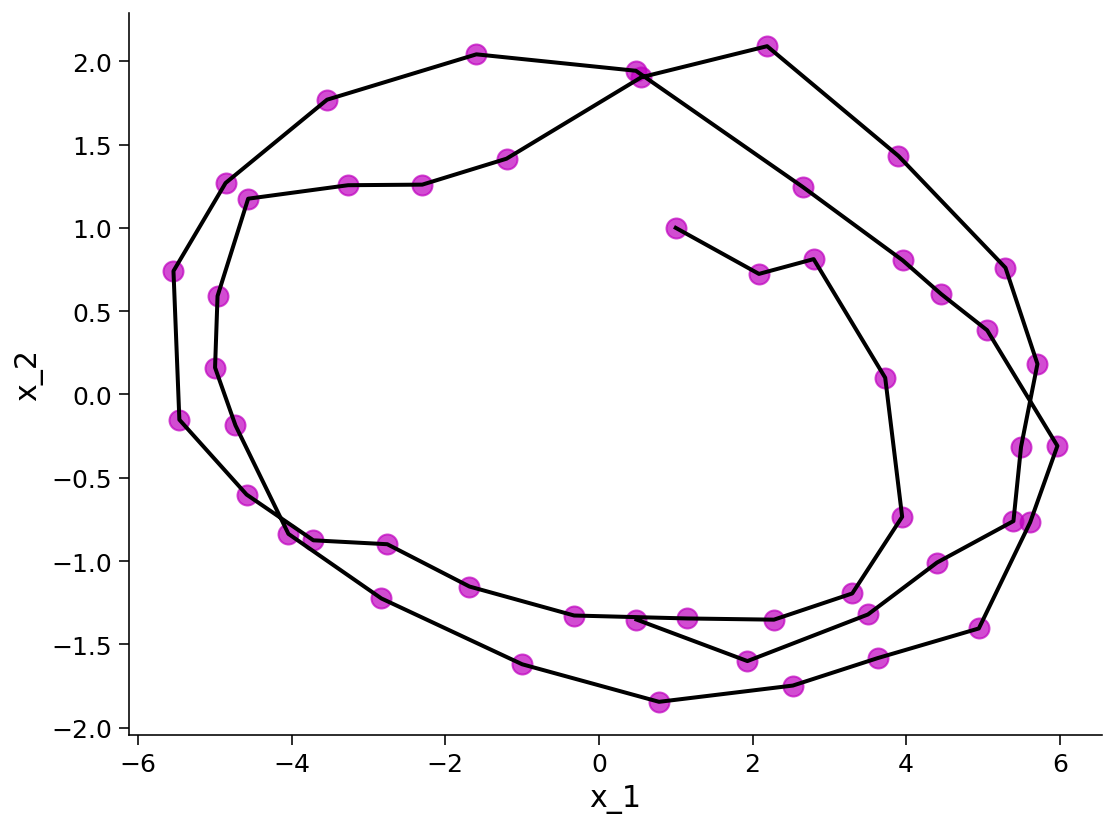

In [5]:
def my_system(nsteps, x0, A, omega_motor, seed=2060):
  """
  my_system is a function that model the time-evolution of a linear dynamical system
  with state transition matrix A.
  Inputs : nsteps is the number of time steps to model
           x0 is the initial state (where we are starting from)
           A is the state-transition matrix
           omega_motor is the covariance matrix
  Outputs : state_evolution is a numpy array that contains the time-evolution of 
            the state vector : (state size, nsteps)
  """
  # Set the random generator seed
  np.random.seed(seed)

  ########################
  #### Your code here ####
  ########################
  #useful parameters 
  state_size = len(x0)

  #Initialization
  state_evolution = np.zeros((state_size, nsteps))
  state_evolution[:,0] = x0

  #Recursion
  for step in range(1, nsteps):
    noise = np.random.multivariate_normal(np.zeros(state_size), omega_motor)
    state_evolution[:, step] = A @ state_evolution[:, step - 1] + noise

  return state_evolution

# Run the lines below to test your code

nsteps = 50
x0 = np.array([1,1]).T
A = np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]])
sigma_motor = 0.05
omega_motor = [[sigma_motor , 0],[0, sigma_motor]]

state_evolution = my_system(nsteps,x0,A,omega_motor)
plot_my_system(state_evolution)


*Example output:*

<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP5_ex1.PNG>




**What is the effect of the motor noise covariance on the behaviour of the system?**


Play with the widget below to explore this effect. 

In [10]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma_motor=widgets.FloatSlider(0.05, min=0, max=1, step=0.05, layout=my_layout)

)

def sigma_motor(sigma_motor = 0.05):
    nsteps = 50
    x0 = np.array([1,1]).T
    A = np.array([[1., 1.], [-(2*np.pi/20.)**2., .9]])
    omega_motor = [[sigma_motor , 0],[0, sigma_motor]]
    state_evolution = my_system(nsteps,x0,A,omega_motor)
    plot_my_system(state_evolution)


interactive(children=(FloatSlider(value=0.05, description='sigma_motor', layout=Layout(width='450px'), max=1.0…

---
##Imperfect measurements

As we saw in the previous tutorials, our sensory inputs are not perfect and it is impossible to know the real latent state; we can only get a rough estimate of it. Mathematically, we define the observation of the latent state of our dynamical system, $y[t]$ as follows: 


$\begin{eqnarray}
& & \\
y[t]& = & H x[t] + \eta[t]\\
 & & \\
\begin{bmatrix}y_1[t]\\ y_2[t]\end{bmatrix} & = &\begin{bmatrix}1 & 0 \\ 0 & 1\end{bmatrix} \begin{bmatrix}x_1[t] \\ x_2[t]\end{bmatrix} + \begin{bmatrix}\eta_1[t]\\ \eta_2[t]\end{bmatrix}
& &\\
\end{eqnarray}$

where $H$ is the called the *observation matrix* and $\eta[t]$ is a vector of Gaussian white sensory noise generated from $\mathcal{N}\left(0,\Omega_{\text{sensory}}\right)$. 

**Exercise - Implement the observation of the latent state**

You will implement a function which simulates first the true state evolution (use the function `my_system`), then takes noisy measurement of these states according to the above relationship. 

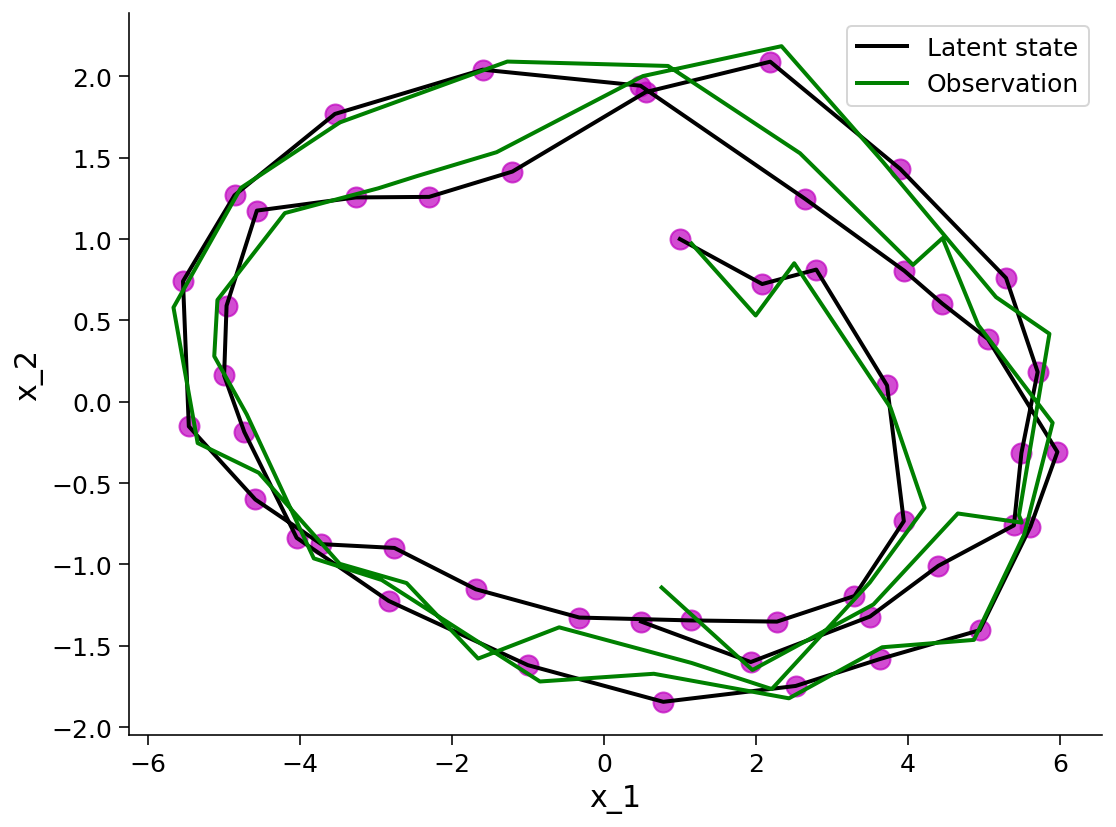

In [7]:
def my_system_with_obs(nsteps,x0,A,H,omega_motor,omega_sensory):
  """
  my_system_with_obs is a function that model the time-evolution of the latent state 
  and its observation
  Inputs : nsteps is the number of time steps to model
           x0 is the initial state (where we are starting from)
           A is the state-transition matrix
           H is the observation matrix
           omega_motor is the variance of the motor noise
           sigma_sensory is the variance of the sensory noise
  Outputs : state_evolution is a numpy array that contains the time-evolution of 
            the state vector : (state size, nsteps)
            obs_evolution is a numpy array that contains the time-evolution of 
            the observation of the state vector : (state size, nsteps)
  """
  ######################
  ### your code here ###
  ######################
  state_evolution = my_system(nsteps, x0, A, omega_motor)

  #Initialization
  obs_evolution = np.zeros_like(state_evolution)

  #Recursion
  for step in range(nsteps):
    noise = np.random.multivariate_normal(np.zeros(len(x0)), omega_sensory)
    obs_evolution[:, step] = H @ state_evolution[:, step] + noise

  return state_evolution,obs_evolution

# Run the lines below to test your code 
np.random.seed(2060)
nsteps = 50
x0 = np.array([1,1]).T
A = np.array([[1.,1.],[-(2*np.pi/20.)**2.,0.9]])
H = np.eye(2)
sigma_motor = 0.05
sigma_sensory_x = 0.02
sigma_sensory_y = 0.03
omega_motor = [[sigma_motor , 0],[0, sigma_motor]]
omega_sensory = [[sigma_sensory_x , 0],[0, sigma_sensory_y]]

state_evolution, obs_evolution = my_system_with_obs(nsteps, x0, A, H, omega_motor, omega_sensory)
plot_my_system_with_obs(state_evolution,obs_evolution)


*Example output:*

<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP5_ex2.PNG>

The green line, corresponding to the measurements, will be used to build your likelihood. To give you more intuition about the meaning of this likelihood, you will implement a simple function `compare` to compare measurements to the values.

You will then call this 1D function on both variables of the system.  



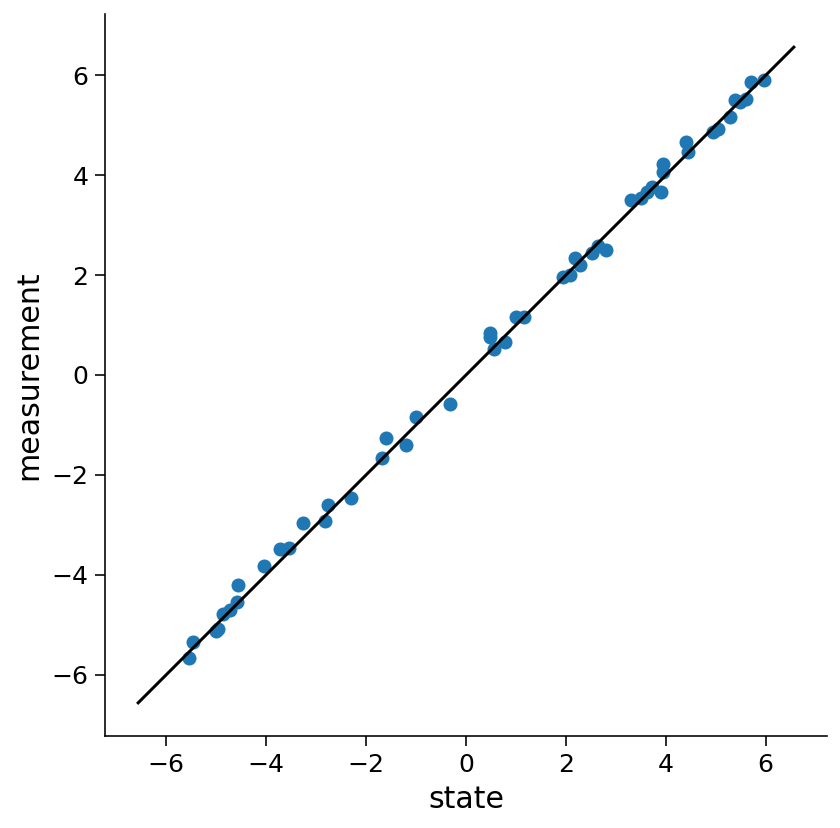

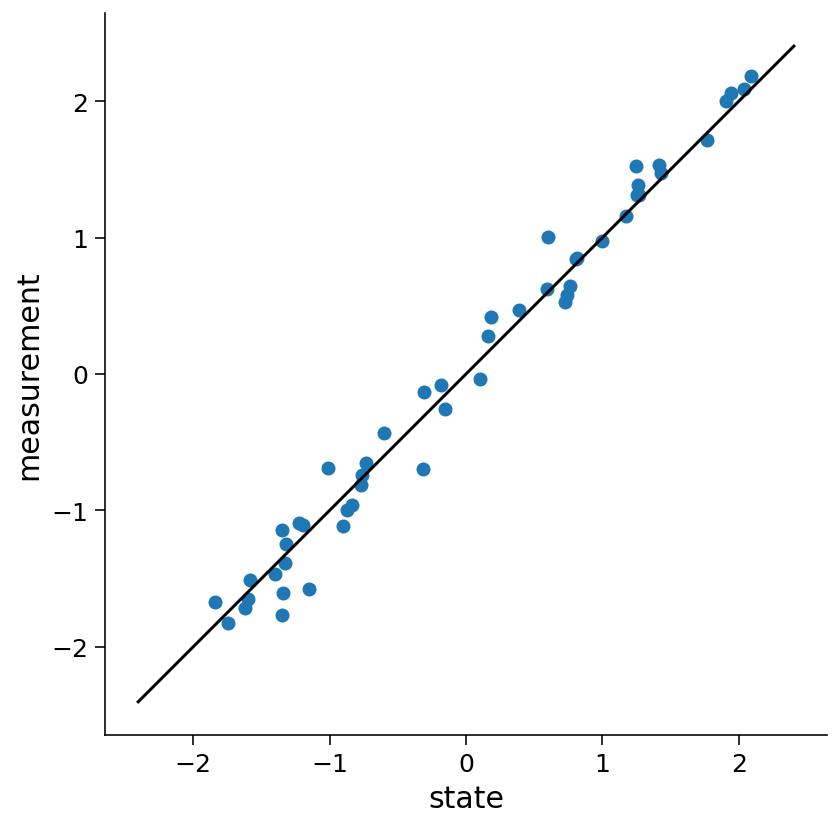

In [9]:
def compare(s, m):
  """ Compute a scatter plot

  Args:
    s (ndarray): astrocat's true position over time
    m (ndarray): astrocat's measured position over time according to the sensor

  """

  fig = plt.figure()
  ax = fig.add_subplot(111)
  sbounds = 1.1*max(max(np.abs(s)), max(np.abs(m)))
  ax.plot([-sbounds, sbounds], [-sbounds, sbounds], 'k')    # plot line of equality
  ax.set_xlabel('state')
  ax.set_ylabel('measurement')
  ax.set_aspect('equal')

  # Complete a scatter plot: true state versus measurements
  #### YOUR CODE HERE ####
  ax.scatter(s, m)

# Visualize true vs measured states (use state_evolution and state_obs from last cell)

#### YOUR CODE HERE ####
#First state and the associated observations
compare(state_evolution[0,:],obs_evolution[0,:])

#Second state and the associated observations
compare(state_evolution[1,:],obs_evolution[1,:])

##Kalman filter, or the optimal estimation of continuous linear dynamical systems

A Kalman filter estimates a posterior probability distribution *recursively* over time using a mathematical model of the process and incoming measurements. This dynamic posterior allows us to improve our guess about the fly's position as new measures arrive. Then the posterior's mean is the best estimate one can compute of fly's actual position at each time step.

Now it's your turn! Follow this recipe to complete the code below and implement your own Kalman filter. To make things easier, we will first only consider a 1D system.   

**Step 1: Change yesterday's posterior into today's prior** 

The first step consists into updating yesterday's posterior into today's prior while taking into account the system dynamics. Recall that yesterday's posterior is a gaussian distribution $\mathcal{N}(\mu_{s_{t-1}}, \sigma_{s_{t-1}}^2)$. The mathematical model of the system is composed of a deterministic shift $a$ and some additional noise. 
-  When you multiply your prior by $a$, you multiply each point of the distribution. Therefore, you will get a new distribution:  $$\mathcal{N}(a*\mu_{s_{t-1}}, a^2*\sigma_{s_{t-1}}^2)$$

- Then, you add the process noise and get: $$\mathcal{N}(a*\mu_{s_{t-1}}, a^2*\sigma_{s_{t-1}}^2 + \sigma_{motor}^2)$$

You have now today's prior ! 

**Step 2: Multiply today's prior by likelihood** 

Use the latest measurement  to form a new estimate somewhere between this measurement and what we predicted in Step 1. The next posterior is the result of multiplying the Gaussian computed in Step 1 (a.k.a. today's prior) and the likelihood, which is also modeled as a Gaussian $\mathcal{N}(m_t, \sigma_{sensory}^2)$:

**2a: add information from prior and likelihood** 

To find the posterior variance, we first compute the posterior information (which is the inverse of the variance) by adding the information provided by the prior and the likelihood:

> $\frac{1}{\sigma_{s_t}^2} = \frac{1}{a^2*\sigma_{s_{t-1}}^2 + \sigma_{motor}^2} + \frac{1}{\sigma_{sensory}^2} $

Now we can take the inverse of the posterior information to get back the posterior variance.

**2b: add means from prior and likelihood** 

To find the posterior mean, we calculate a weighted average of means from prior and likelihood, where each weight, $g$, is just the fraction of information that each Gaussian provides!

> $g_{\rm{prior}} = \frac{\rm{information}_{\textit{ }\rm{prior}}}{\rm{information}_{\textit{ }\rm{posterior}}}$
>
> $g_{\rm{likelihood}} = \frac{\rm{information}_{\textit{ }\rm{likelihood}}}{\rm{information}_{\textit{ }\rm{posterior}}}$
>
> $\bar{\mu}_t = g_{\rm{prior}}* a*\mu_{s_{t-1}} + g_{\rm{likelihood}}* m_t$ 
    

**Implementation detail:** 
Recall that the best estimate is the mean of the posterior distribution and the associated variance can be computed based on the information of the prior and the likelihood.


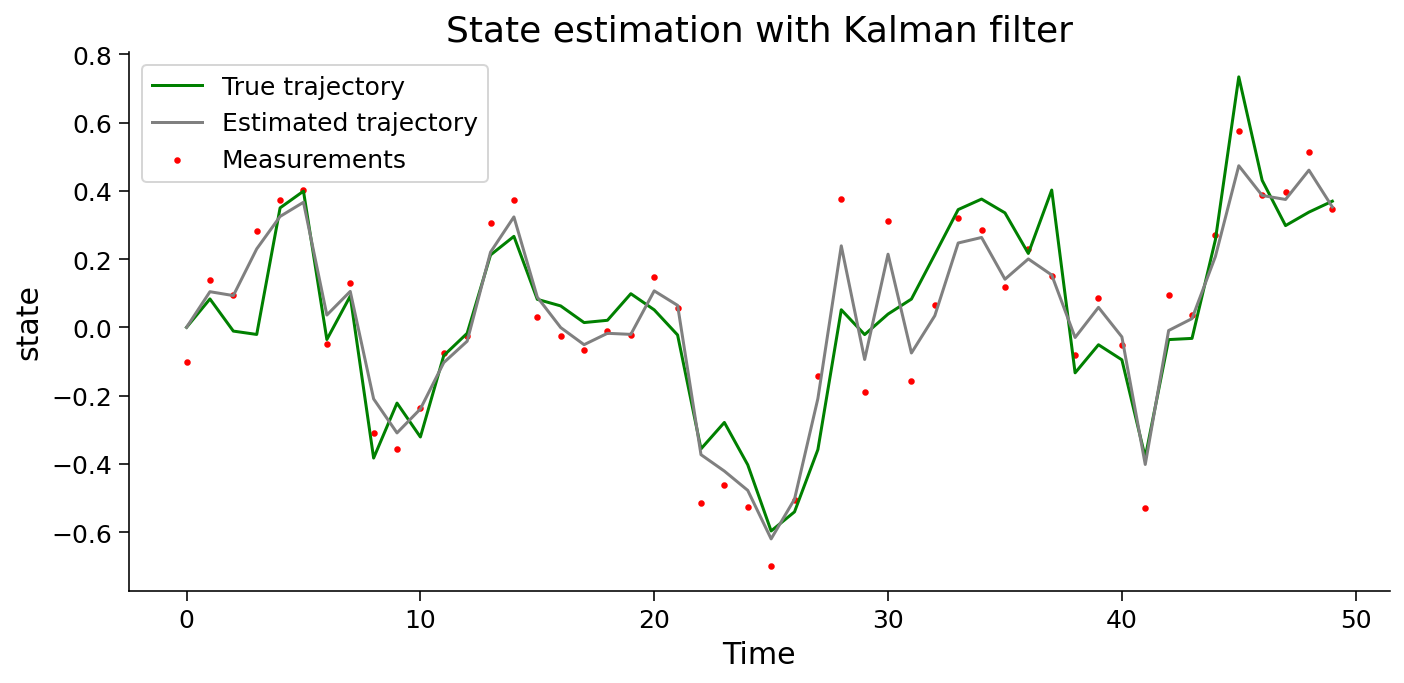

In [29]:
def Kalman_filter_1D(x0, M, a, sigma_start, sigma_motor, sigma_sensory):
  """
  my_kalman_filter computes and applies the Kalman filter to the system seen above
  Inputs : x0 is the initial state (where we are starting from, first prior)
           M is the vector of measurements (do not use M[0], the measurement on the initial state)
           a is the deterministic parameter of the system
           sigma_start is the variance associated with the initial state
           sigma_motor is the variance of the noise of the system
           sigma_sensory is the variance of the noise on the measurement
  Outputs : estimated_state is a numpy array that contains the time-evolution of 
              the estimation of the state vector
            estimates_cov is a numpy array that contains the uncertainty 
              (variance) associated with your posterior estimates
  """
  ##########################
  ##### Your code here #####
  ##########################
  #Initialization 
  estimated_state = np.zeros(M.shape[0])
  estimates_cov = np.zeros(M.shape[0])

  #First estimate
  estimated_state[0] = x0
  estimates_cov[0] = sigma_start

  #Iterate for each estimate
  for i in range(1, M.shape[0]):
    info_prior = 1 / (a**2 * estimates_cov[i-1] + sigma_motor)
    info_likelihood = 1 / sigma_sensory
    info_posterior = info_prior + info_likelihood

    #Best estimate = mean of posterior
    g_prior = info_prior/info_posterior
    g_likelihood = info_likelihood/info_posterior
    mu = g_prior * a * estimated_state[i-1] + g_likelihood * M[i]
    estimated_state[i] = mu

    #variance of posterior
    estimates_cov[i] = 1 / (info_posterior)

  return estimated_state, estimates_cov

#Parameters
omega_motor = 0.05
omega_sensory = 0.02
omega_start = omega_sensory
x0 = 0.0
a = 0.8
nsteps = 50
H = 1

#Call the functions
true_states, M = my_system_with_obs1D(nsteps, x0, a, H, omega_motor, omega_sensory)
estimate, cov = Kalman_filter_1D(x0, M, a, omega_start, omega_motor, omega_sensory)

#Create distributions
x0_distr = gaussian(0, omega_motor/(1-a**2))

#paintMyFilter(a, x0_distr, omega_motor, omega_sensory, true_states, M, estimate, cov)

#Let's try to reproduce the fancy graph
t = np.arange(nsteps)
plt.figure(figsize=(10, 5))
plt.plot(t, true_states, color="green", label="True trajectory")
plt.scatter(t, M, s=5, color="red", label="Measurements")
plt.plot(t, estimate, color="grey", label="Estimated trajectory")
plt.legend(loc="upper left")
plt.title("State estimation with Kalman filter")
plt.ylabel("state")
plt.xlabel("Time")
plt.show()

*Example output:*

<img alt='Solution hint' align='left' width=900 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP5_ex3.PNG>

**Bonus : Relationship to classic description of Kalman filter:**

We're teaching this recipe because it is interpretable and connects to past lessons about the bayesian inference. But the classic description of the Kalman filter is a little different. The above weights, $g_{\rm{prior}}$ and $g_{\rm{likelihood}}$, add up to $1$ and can be written one in terms of the other; then, if we define the Kalman gain $K = g_{\rm{likelihood}}$, then $g_{\rm{prior}} = 1-K$. 

In classic textbooks, you will often find the following expression: 

$\begin{eqnarray}
& & \\
\hat{x}[t+1] & = & A  \hat{x}[t]+ K[t]\left(y[t] - H \hat{x}[t]\right)\\
& & \\
\end{eqnarray}$


Where $K[t]$ is the Kalman gain evaluated at time $t$. These Kalman gains will be the weighting parameters that characterises how much we trust one source of information (prior and likelihood) over the other. Since these gains quantifies the trust we have in each source, they will be computed based on the covariances matrices of these two sources. The covariance matrix related to the prior is $\Omega_{\text{motor}}$ and the one related to the likelihood is $\Omega_{\text{sensory}}$. Therefore the gain of the kalman filter are recursively computed as follows:  

$\begin{eqnarray}
& & \\
K[t]& = &A\, \Sigma[t] \,H^T \left(H \,\Sigma[t]\,H^T+\Omega_{\text{motor}}\right)^{-1} \\
& & \\
\Sigma[t+1] & = & \Omega_{\text{sensory}} + \left(A-K[t]\,H\right)\Sigma[t]\,A^T
\end{eqnarray}$

Where $\Sigma[t] = \mathbb{C}\text{ov}\left\{\hat{x}[t]\right\}$ is the covariance matrix of the estimated state at time t. 


**Exercice - Implement the function below to apply Kalman filter in 2D to the dynamical linear system**


In [ ]:
def my_kalman_filter(nsteps,x0,A,H,omega_motor,omega_sensory,seed=2060):
  """
  my_kalman_filter computes and applies the Kalman filter to the system seen above
  Inputs : nsteps is the number of time steps to model
           x0 is the initial state (where we are starting from)
           A is the state-transition matrix
           H is the observation matrix
  Outputs : latent_state is a numpy array that contains the time-evolution of 
             the state vector : (state size * nsteps)
            observed_state is a numpy array that contains the time-evolution of 
             the observation of the state vector : (state size * nsteps)
            estimated_state is a numpy array that contains the time-evolution of 
              the estimation of the state vector : (state size * nsteps)
            K kalman gains: (state size * state size * nsteps)
  """
  np.random.seed(seed)

  ####################
  ## your code here ##
  ####################
  
  #HINT
  #You can find some help in this video : https://www.youtube.com/watch?v=dQw4w9WgXcQ&ab_channel=RickAstley


  return latent_state,observed_state, estimated_state, K


# Run the lines below to test your code

# Parameters definition
nsteps = 50
A = np.array([[1.,1.],[-(2*np.pi/20.)**2.,0.9]])
H = np.eye(2)
x0 = np.array([1,1]).T
omega_motor = 0.05 * np.eye(len(x0))
sigma_sensory_x = 0.02
sigma_sensory_y = 0.03
omega_sensory = [[sigma_sensory_x , 0],[0, sigma_sensory_y]]


####################
## your code here ##
####################

plot_my_kalman_filter(state_evolution, obs_evolution, estimated_evolution)

*Example output:*

<img alt='Solution hint' align='left' width=413 height=300 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/TP5_ex4.PNG>